Anticipez les besoins en consommation électrique de bâtiments
=============================================================

![logo-seattle](../reports/figures/logo-seattle.png)


Explication des variables:
[City of seattle](https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m)

## Importation des librairies

In [1]:
import os
import pandas as pd
import folium
from folium.plugins import FastMarkerCluster
import json

from src.utils.units import Converter
from src.features.univar import UnivariateAnalysis
from src.features.bivar import BivariateAnalysis

## Chargement des données

In [2]:
data = dict()
data_dir = os.path.abspath('../data/raw')
for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        key = file.split('.')[0]
        data[key] = pd.read_csv(os.path.join(data_dir, file))

In [3]:
data = pd.concat(data, sort=False)

In [4]:
data

OSEBuildingID  DataYear  \
2015-building-energy-benchmarking 0                 1      2015   
                                  1                 2      2015   
                                  2                 3      2015   
                                  3                 5      2015   
                                  4                 8      2015   
...                                               ...       ...   
2016-building-energy-benchmarking 3371          50222      2016   
                                  3372          50223      2016   
                                  3373          50224      2016   
                                  3374          50225      2016   
                                  3375          50226      2016   

                                              BuildingType  \
2015-building-energy-benchmarking 0         NonResidential   
                                  1         NonResidential   
                                  2         NonResidential   
                                  3         NonResidential   
                                  4         NonResidential   
...                                                    ...   
2016-building-energy-benchmarking 3371  Nonresidential COS   
                                  3372  Nonresidential COS   
                                  3373  Nonresidential COS   
                                  3374  Nonresidential COS   
                                  3375  Nonresidential COS   

                                       PrimaryPropertyType  \
2015-building-energy-benchmarking 0                  Hotel   
                                  1                  Hotel   
                                  2                  Hotel   
                                  3                  Hotel   
                                  4                  Hotel   
...                                                    ...   
2016-building-energy-benchmarking 3371              Office   
                                  3372               Other   
                                  3373               Other   
                                  3374  Mixed Use Property   
                                  3375  Mixed Use Property   

                                                               PropertyName  \
2015-building-energy-benchmarking 0                    MAYFLOWER PARK HOTEL   
                                  1                         PARAMOUNT HOTEL   
                                  2                            WESTIN HOTEL   
                                  3                               HOTEL MAX   
                                  4                   WARWICK SEATTLE HOTEL   
...                                                                     ...   
2016-building-energy-benchmarking 3371                Horticulture building   
                                  3372  International district/Chinatown CC   
                                  3373                      Queen Anne Pool   
                                  3374          South Park Community Center   
                                  3375          Van Asselt Community Center   

                                       TaxParcelIdentificationNumber  \
2015-building-energy-benchmarking 0                        659000030   
                                  1                        659000220   
                                  2                        659000475   
                                  3                        659000640   
                                  4                        659000970   
...                                                              ...   
2016-building-energy-benchmarking 3371                    1624049080   
                                  3372                    3558300000   
                                  3373                    1794501150   
                                  3374                    7883603155   
    

In [5]:
data.rename({"2015-building-energy-benchmarking" : 2015,
             "2016-building-energy-benchmarking" : 2016}, inplace=True)

### Correction des types de données

In [6]:
categorical_fields = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
                      'LargestPropertyUseType', 'SecondLargestPropertyUseType',
                      'ThirdLargestPropertyUseType']
for col in categorical_fields:
    data[col] = data[col].astype('category')

In [7]:
for col in data.columns:
    print(f"col : {col} dtype : {data[col].dtype}")

col : OSEBuildingID dtype : int64
col : DataYear dtype : int64
col : BuildingType dtype : category
col : PrimaryPropertyType dtype : category
col : PropertyName dtype : object
col : TaxParcelIdentificationNumber dtype : object
col : Location dtype : object
col : CouncilDistrictCode dtype : int64
col : Neighborhood dtype : category
col : YearBuilt dtype : int64
col : NumberofBuildings dtype : float64
col : NumberofFloors dtype : float64
col : PropertyGFATotal dtype : int64
col : PropertyGFAParking dtype : int64
col : PropertyGFABuilding(s) dtype : int64
col : ListOfAllPropertyUseTypes dtype : object
col : LargestPropertyUseType dtype : category
col : LargestPropertyUseTypeGFA dtype : float64
col : SecondLargestPropertyUseType dtype : category
col : SecondLargestPropertyUseTypeGFA dtype : float64
col : ThirdLargestPropertyUseType dtype : category
col : ThirdLargestPropertyUseTypeGFA dtype : float64
col : YearsENERGYSTARCertified dtype : object
col : ENERGYSTARScore dtype : float64
col : 

In [8]:
location = lambda x : x if pd.isna(x) else eval(x)
data['Location'] = data['Location'].apply(location)

### Localisation des bâtiments

On ne regarde que pour l'année 2016 (En principe les bâtiments contenus dans le set 2015 sont repris dans celui de 2016)

In [9]:
m = folium.Map(location=(47.6, -122.3),
               tiles='cartodbpositron',
               zoom_start=12)

mc = FastMarkerCluster(data.loc[2016, ['Latitude', 'Longitude']].values.tolist())
mc.add_to(m)

m

In [10]:
conversion_rate = data['Electricity(kBtu)'] / data['Electricity(kWh)']

### Conversion des unités au format SI

In [11]:
def convert_data_to_si_unit(data):
    for col in data.columns:
        if "(kbtu)" in col.lower():
            print(col)
            data[col] = data[col].apply(Converter.kbtu_to_kwh)
            col_2 = col.replace("(kBtu)", "(kwh)")
            data.rename(columns={col: col_2}, inplace=True)
            
        elif "(kbtu/sf)" in col.lower():
            print(col)
            data[col] = data[col].apply(Converter.kbtu_per_sf_to_kwh_per_sm)
            col_2 = col.replace("(kBtu/sf)", "(kwh/m2)")
            data.rename(columns={col: col_2}, inplace=True)
            
        else:
            pass


In [12]:
convert_data_to_si_unit(data)

SiteEUI(kBtu/sf)
SiteEUIWN(kBtu/sf)
SourceEUI(kBtu/sf)
SourceEUIWN(kBtu/sf)
SiteEnergyUse(kBtu)
SiteEnergyUseWN(kBtu)
SteamUse(kBtu)
Electricity(kBtu)
NaturalGas(kBtu)
OtherFuelUse(kBtu)


In [13]:
data.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,...,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,ZipCode,Latitude,Longitude,Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,6716.000000,6716.00000,6716.000000,6716.000000,6708.000000,6708.000000,6.716000e+03,6716.000000,6.716000e+03,6.560000e+03,...,3338.000000,213.000000,3338.000000,3340.000000,3360.000000,3376.000000,3376.000000,0.0,3367.000000,3367.000000
mean,20867.420488,2015.50268,4.445057,1968.101549,1.071407,4.695736,9.281410e+04,9519.597975,8.329450e+04,7.707936e+04,...,32.380168,1.347418,24.825644,18786.680240,98116.949107,47.624033,-122.334795,NaN,119.723971,1.175916
std,11878.968174,0.50003,2.123749,33.020391,1.593505,5.476218,1.875062e+05,33868.050881,1.733470e+05,1.681617e+05,...,19.907567,0.477272,15.006287,588.604192,18.615205,0.047758,0.027203,NaN,538.832227,1.821452
min,1.000000,2015.00000,1.000000,1900.000000,0.000000,0.000000,1.128500e+04,-3.000000,-5.055000e+04,5.656000e+03,...,1.000000,1.000000,1.000000,17916.000000,98006.000000,47.499170,-122.414250,NaN,-0.800000,-0.020000
25%,19934.000000,2015.00000,3.000000,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.727300e+04,2.501600e+04,...,14.000000,1.000000,10.000000,18379.000000,98105.000000,47.599860,-122.350662,NaN,9.495000,0.210000
50%,23064.000000,2016.00000,4.000000,1974.000000,1.000000,4.000000,4.400800e+04,0.000000,4.218500e+04,3.953000e+04,...,33.000000,1.000000,26.000000,18390.000000,98115.000000,47.618675,-122.332495,NaN,33.920000,0.610000
75%,25868.250000,2016.00000,7.000000,1996.000000,1.000000,5.000000,8.943125e+04,0.000000,8.112000e+04,7.417800e+04,...,50.000000,2.000000,38.000000,19576.000000,98122.000000,47.657115,-122.319407,NaN,93.940000,1.370000
max,50226.000000,2016.00000,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,...,61.000000,2.000000,51.000000,19584.000000,98272.000000,47.733870,-122.220966,NaN,16870.980000,34.090000


In [14]:
data['SiteEUI(kwh/m2)'].describe()

count    6699.000000
mean      170.923111
std       173.823179
min         0.000000
25%        87.066706
50%       119.874448
75%       189.906363
max      2632.190597
Name: SiteEUI(kwh/m2), dtype: float64

In [15]:
for col in data.columns:
    print(col)

OSEBuildingID
DataYear
BuildingType
PrimaryPropertyType
PropertyName
TaxParcelIdentificationNumber
Location
CouncilDistrictCode
Neighborhood
YearBuilt
NumberofBuildings
NumberofFloors
PropertyGFATotal
PropertyGFAParking
PropertyGFABuilding(s)
ListOfAllPropertyUseTypes
LargestPropertyUseType
LargestPropertyUseTypeGFA
SecondLargestPropertyUseType
SecondLargestPropertyUseTypeGFA
ThirdLargestPropertyUseType
ThirdLargestPropertyUseTypeGFA
YearsENERGYSTARCertified
ENERGYSTARScore
SiteEUI(kwh/m2)
SiteEUIWN(kwh/m2)
SourceEUI(kwh/m2)
SourceEUIWN(kwh/m2)
SiteEnergyUse(kwh)
SiteEnergyUseWN(kwh)
SteamUse(kwh)
Electricity(kWh)
Electricity(kwh)
NaturalGas(therms)
NaturalGas(kwh)
OtherFuelUse(kwh)
GHGEmissions(MetricTonsCO2e)
GHGEmissionsIntensity(kgCO2e/ft2)
DefaultData
Comment
ComplianceStatus
Outlier
2010 Census Tracts
Seattle Police Department Micro Community Policing Plan Areas
City Council Districts
SPD Beats
Zip Codes
Address
City
State
ZipCode
Latitude
Longitude
Comments
TotalGHGEmissions
GHG

Les données de base contiennent la consommation électrique en kWh et kBtu. On peut s'assure donc que la conversion
des unités est correct en faisant le rapport de la colonne d'origine et celle que l'on a calculé.

On remarque que la conversion utilisée dans le dataset n'est pas constante. (Erreur d'arrondi, de type?)

In [16]:
data['Electricity(kWh)'] / data['Electricity(kwh)']

2015  0       1.000000
      1       1.000000
      2       1.000000
      3       1.000001
      4       1.000000
                ...   
2016  3371    1.000042
      3372    1.000042
      3373    1.000042
      3374    1.000042
      3375    1.000042
Length: 6716, dtype: float64

## Analyses univariées

In [17]:
univar = UnivariateAnalysis(data)

completion rate -- YearBuilt : 100.0 %


mean,std,min,max,median,variance,25%,75%
1968.1015485407981,33.02039069457709,1900,2015,1974.0,1090.3462016225133,1948.0,1996.0


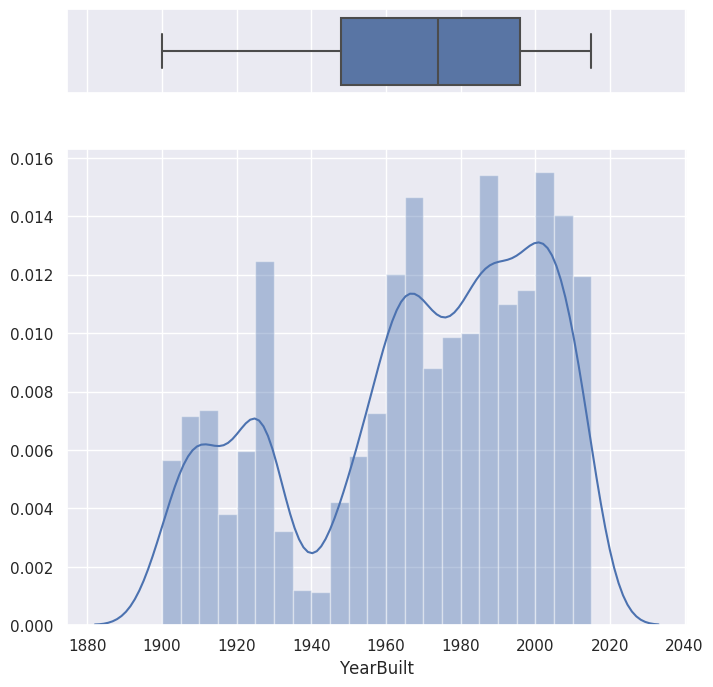

In [18]:
univar.make_analysis('YearBuilt')

completion rate -- SiteEnergyUse(kwh) : 99.77665276950566 %


mean,std,min,max,median,variance,25%,75%
1522408.45594422,5315276.254494498,0.0,256121757.7670163,524911.2051226582,28252161661593.055,269645.5700834917,1211931.0094760612


/home/thibault/Documents/openclassrooms/projects/seattle_energy/src/features/univar.py:58: UserWarning: NaN detected in the series. NaNs are not considered for calculation.
  warnings.warn('NaN detected in the series.'


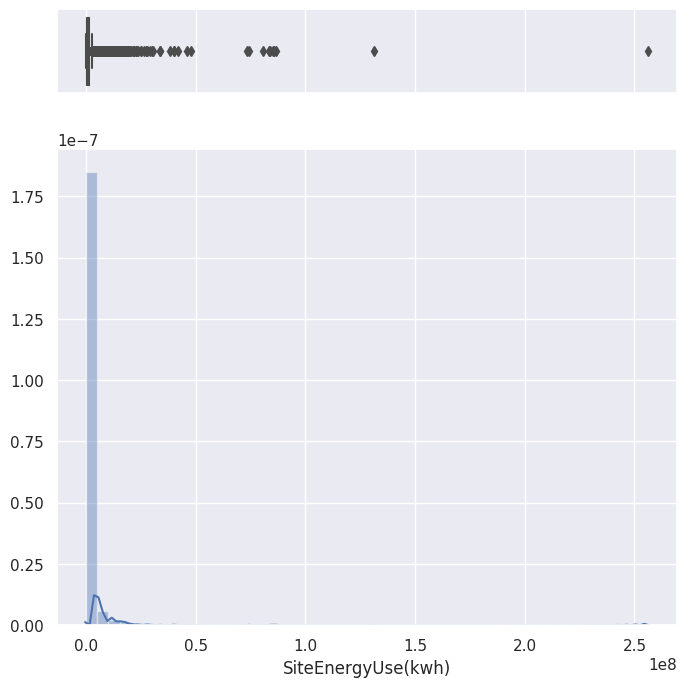

In [19]:
univar.make_analysis('SiteEnergyUse(kwh)')

In [20]:
lower, upper = univar.outliers_infos('SiteEnergyUse(kwh)', lower_trig=0.01, upper_trig=0.99)

In [21]:
upper[['SiteEnergyUse(kwh)', 'PropertyName', 'BuildingType']].sort_values(by='SiteEnergyUse(kwh)')

SiteEnergyUse(kwh)                               PropertyName  \
2015 376         1.639670e+07                         SEATTLE ART MUSEUM   
2016 262         1.655418e+07                   Fairmont Olympic Seattle   
     490         1.655818e+07                 Russell Investments Center   
     273         1.658962e+07                             US Bank Centre   
2015 261         1.663542e+07                              RAINIER TOWER   
...                       ...                                        ...   
2016 618         8.546375e+07                         Swedish First Hill   
     170         8.589643e+07                  Harborview Medical Center   
2015 170         8.669413e+07                  HARBORVIEW MEDICAL CENTER   
2016 35          1.314088e+08                               Plant 2 Site   
     3274        2.561218e+08  University of Washington - Seattle Campus   

             BuildingType  
2015 376   NonResidential  
2016 262   NonResidential  
     490   NonResidential  
     273   NonResidential  
2015 261   NonResidential  
...                   ...  
2016 618   NonResidential  
     170   NonResidential  
2015 170   NonResidential  
2016 35            Campus  
     3274          Campus  

[67 rows x 3 columns]

In [22]:
lower[['SiteEnergyUse(kwh)', 'PropertyName', 'BuildingType']].sort_values(by='SiteEnergyUse(kwh)')

SiteEnergyUse(kwh)                   PropertyName  \
2015 44              0.000000          CENTURY SQUARE RETAIL   
2016 62              0.000000       Arbor Heights Elementary   
     81              0.000000                 Pathfinder K-8   
     85              0.000000           John Muir Elementary   
     95              0.000000            B.F. Day Elementary   
...                       ...                            ...   
2015 1043        44363.926360            ALASKA COPPER WORKS   
2016 595         44474.794238          Westcore River Street   
2015 1907        44487.602352                ANNE VISTA APTS   
2016 2476        45366.843054      West Olympic Condominiums   
2015 2508        45539.727495  WEST OLYMPIC VIEW CONDOMINIUM   

                   BuildingType  
2015 44          NonResidential  
2016 62       SPS-District K-12  
     81       SPS-District K-12  
     85       SPS-District K-12  
     95       SPS-District K-12  
...                         ...  
2015 1043        NonResidential  
2016 595         NonResidential  
2015 1907  Multifamily LR (1-4)  
2016 2476  Multifamily LR (1-4)  
2015 2508  Multifamily LR (1-4)  

[67 rows x 3 columns]

## Analyses bivariées

### Correlation entre l'année de construction et la consommation ? 

In [23]:
data.rename(columns={'SiteEnergyUse(kwh)': 'SiteEnergyUse',
                     'SiteEUI(kwh/m2)' : 'SiteEUI'
                    }, inplace=True)

In [24]:
data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'Location',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI',
       'SiteEUIWN(kwh/m2)', 'SourceEUI(kwh/m2)', 'SourceEUIWN(kwh/m2)',
       'SiteEnergyUse', 'SiteEnergyUseWN(kwh)', 'SteamUse(kwh)',
       'Electricity(kWh)', 'Electricity(kwh)', 'NaturalGas(therms)',
       'NaturalGas(kwh)', 'OtherFuelUse(kwh)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'DefaultData', 'Comment',
       'ComplianceSt

In [25]:
data[['YearBuilt', 'SiteEnergyUse']].corr()

,YearBuilt,SiteEnergyUse
YearBuilt,1.00000,0.04875
SiteEnergyUse,0.04875,1.00000


In [26]:
bivar = BivariateAnalysis(data.loc[2016])

,YearBuilt,SiteEUI
YearBuilt,1.000000,-0.019642
SiteEUI,-0.019642,1.000000


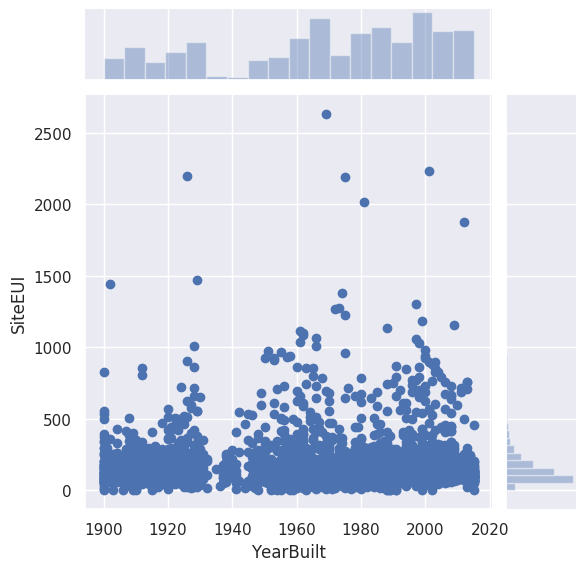

In [27]:
bivar.get_correlation(['YearBuilt', 'SiteEUI'], method='pearson')
bivar.scatterplot(['YearBuilt', 'SiteEUI'])

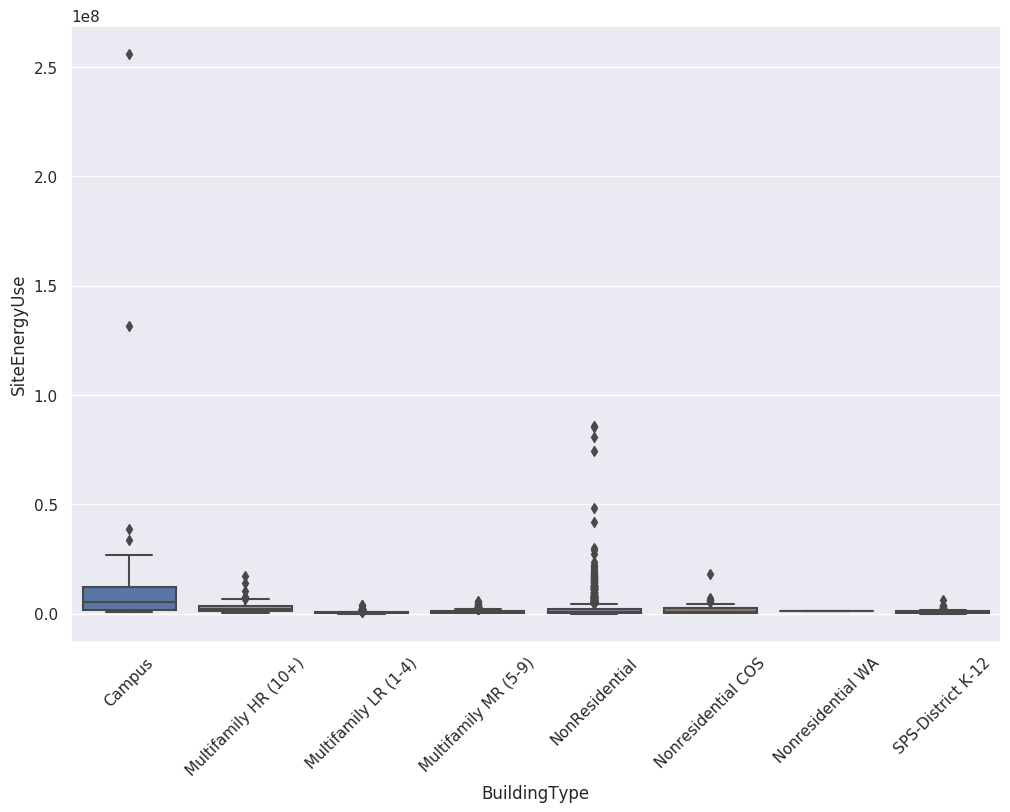

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SiteEnergyUse   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     57.59
Date:                Sat, 18 Jan 2020   Prob (F-statistic):           2.77e-78
Time:                        13:42:07   Log-Likelihood:                -57386.
No. Observations:                3371   AIC:                         1.148e+05
Df Residuals:                    3363   BIC:                         1.148e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                2.382e+07   1.22e+06     19.479      0.000    2.14e+07    2.62e+07
C(BuildingType)[T.Multifamily HR (10+)] -2.102e+07   1.35e+06    -15.573      0.000   -2.37e+07   -1.84e+07
C(BuildingType)[T.Multifamily LR (1-4)] -2.341e+07   1.24e+06    -18.920      0.000   -2.58e+07    -2.1e+07
C(BuildingType)[T.Multifamily MR (5-9)] -2.297e+07   1.25e+06    -18.407      0.000   -2.54e+07   -2.05e+07
C(BuildingType)[T.NonResidential]       -2.155e+07   1.23e+06    -17.480      0.000    -2.4e+07   -1.91e+07
C(BuildingType)[T.Nonresidential COS]   -2.207e+07   1.38e+06    -15.939      0.000   -2.48e+07   -1.94e+07
C(BuildingType)[T.Nonresidential WA]    -2.289e+07   6.11e+06     -3.743      0.000   -3.49e+07   -1.09e+07
C(BuildingType)[T.SPS-District K-12]     -2.29e+07   1.36e+06    -16.785      0.000   -2.56e+07   -2.02e+07
==============================================================================
Omnibus:                     7808.136   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         77667065.409
Skew:                          22.161   Prob(JB):                         0.00
Kurtosis:                     745.287   Cond. No.                         68.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,sum_sq,df,F,PR(>F)
C(BuildingType),1.447042e+16,7.0,57.593097,2.768069e-78
Residual,1.207090e+17,3363.0,NaN,NaN


In [28]:
anova_res = bivar.anova(outcome_variable='SiteEnergyUse', group='BuildingType')

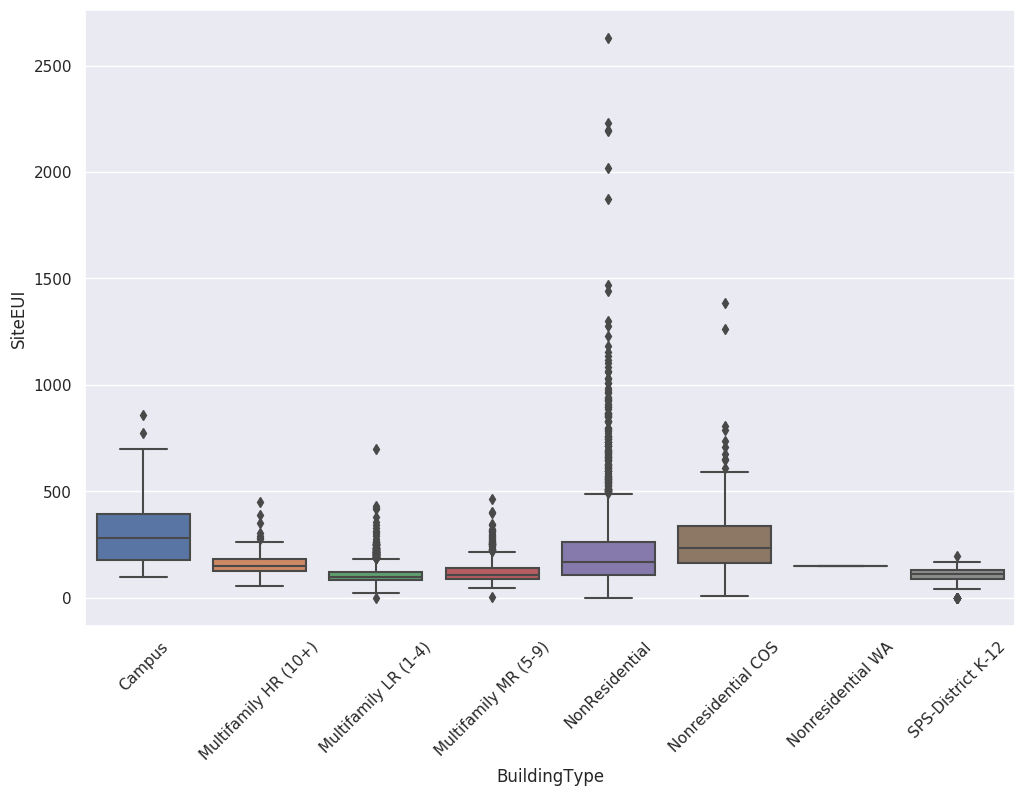

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SiteEUI   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     64.02
Date:                Sat, 18 Jan 2020   Prob (F-statistic):           7.50e-87
Time:                        13:42:07   Log-Likelihood:                -22017.
No. Observations:                3369   AIC:                         4.405e+04
Df Residuals:                    3361   BIC:                         4.410e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 333.7294     34.073      9.795      0.000     266.923     400.535
C(BuildingType)[T.Multifamily HR (10+)]  -172.8195     37.607     -4.595      0.000    -246.554     -99.085
C(BuildingType)[T.Multifamily LR (1-4)]  -222.0295     34.474     -6.441      0.000    -289.622    -154.438
C(BuildingType)[T.Multifamily MR (5-9)]  -210.0869     34.771     -6.042      0.000    -278.261    -141.913
C(BuildingType)[T.NonResidential]        -103.1834     34.353     -3.004      0.003    -170.537     -35.829
C(BuildingType)[T.Nonresidential COS]     -37.9773     38.585     -0.984      0.325    -113.629      37.675
C(BuildingType)[T.Nonresidential WA]     -187.9873    170.365     -1.103      0.270    -522.017     146.043
C(BuildingType)[T.SPS-District K-12]     -233.6613     38.017     -6.146      0.000    -308.200    -159.122
==============================================================================
Omnibus:                     3476.285   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           287114.437
Skew:                           4.988   Prob(JB):                         0.00
Kurtosis:                      47.111   Cond. No.                         68.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,sum_sq,df,F,PR(>F)
C(BuildingType),1.248670e+07,7.0,64.02012,7.498549e-87
Residual,9.364868e+07,3361.0,NaN,NaN


(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f0485643390>,
                        sum_sq      df         F        PR(>F)
 C(BuildingType)  1.248670e+07     7.0  64.02012  7.498549e-87
 Residual         9.364868e+07  3361.0       NaN           NaN)

In [29]:
bivar.anova(outcome_variable='SiteEUI', group='BuildingType')

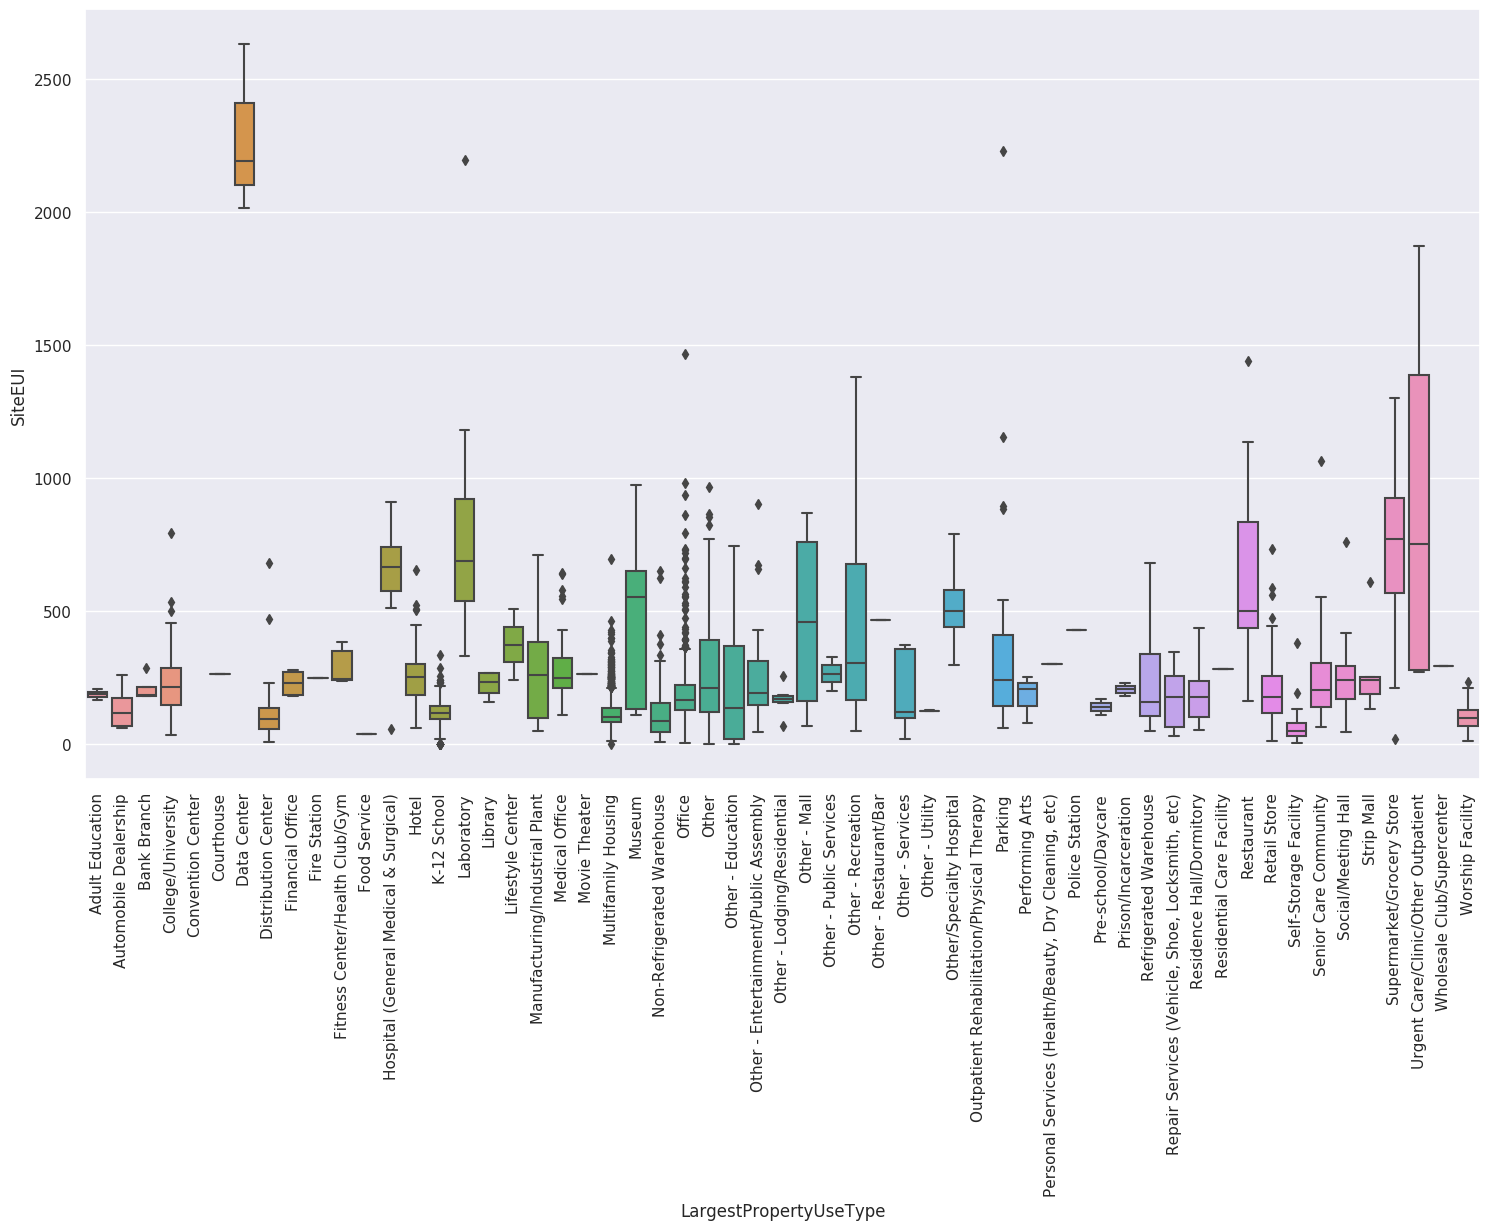

/home/thibault/Documents/openclassrooms/projects/seattle_energy/env/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 56, but rank is 54
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SiteEUI   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     64.51
Date:                Sat, 18 Jan 2020   Prob (F-statistic):               0.00
Time:                        13:43:05   Log-Likelihood:                -20927.
No. Observations:                3354   AIC:                         4.196e+04
Df Residuals:                    3299   BIC:                         4.230e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================
                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                           187.5404     88.422      2.121      0.034      14.172     360.909
C(LargestPropertyUseType)[T.Automobile Dealership]                                  -50.9466    104.623     -0.487      0.626    -256.079     154.186
C(LargestPropertyUseType)[T.Bank Branch]                                             22.3976    108.295      0.207      0.836    -189.935     234.730
C(LargestPropertyUseType)[T.College/University]                                      57.6975     91.891      0.628      0.530    -122.472     237.867
C(LargestPropertyUseType)[T.Convention Center]                                     2.254e-12   1.36e-12      1.661      0.097   -4.06e-13    4.91e-12
C(LargestPropertyUseType)[T.Courthouse]                                              76.4988    153.152      0.499      0.617    -223.784     376.782
C(LargestPropertyUseType)[T.Data Center]                                           2093.0184    114.153     18.335      0.000    1869.201    2316.836
C(LargestPropertyUseType)[T.Distribution Center]                                    -78.5435     90.045     -0.872      0.383    -255.093      98.006
C(LargestPropertyUseType)[T.Financial Office]                                        42.2715    108.295      0.390      0.696    -170.061     254.604
C(LargestPropertyUseType)[T.Fire Station]                                            63.2495    153.152      0.413      0.680    -237.033     363.532
C(LargestPropertyUseType)[T.Fitness Center/Health Club/Gym]                         104.8901    104.623      1.003      0.316    -100.242     310.022
C(LargestPropertyUseType)[T.Food Service]                                          -147.4771    153.152     -0.963      0.336    -447.760     152.806
C(LargestPropertyUseType)[T.Hospital (General Medical & Surgical)]                  433.9455     96.862      4.480      0.000     244.030     623.861
C(LargestPropertyUseType)[T.Hotel]                                                   69.6489     89.563      0.778      0.437    -105.957     245.254
C(LargestPropertyUseType)[T.K-12 School]                                            -68.9505     89.056     -0.774      0.439    -243.562     105.661
C(LargestPropertyUseType)[T.Laboratory]                                             624.4998     94.981      6.575      0.000     438.272     810.727
C(LargestPropertyUseType)[T.Library]                                                 37.0664    108.295      0.342      0.732    -175.266     249.399
C(LargestPropertyUseType)[T.Lifestyle Center]                                      

,sum_sq,df,F,PR(>F)
C(LargestPropertyUseType),5.649218e+07,56.0,64.512694,0.0
Residual,5.158666e+07,3299.0,NaN,NaN


In [32]:
_ = bivar.anova(outcome_variable='SiteEUI', 
                group='LargestPropertyUseType', 
                figsize=(18, 10), label_rotation=90)

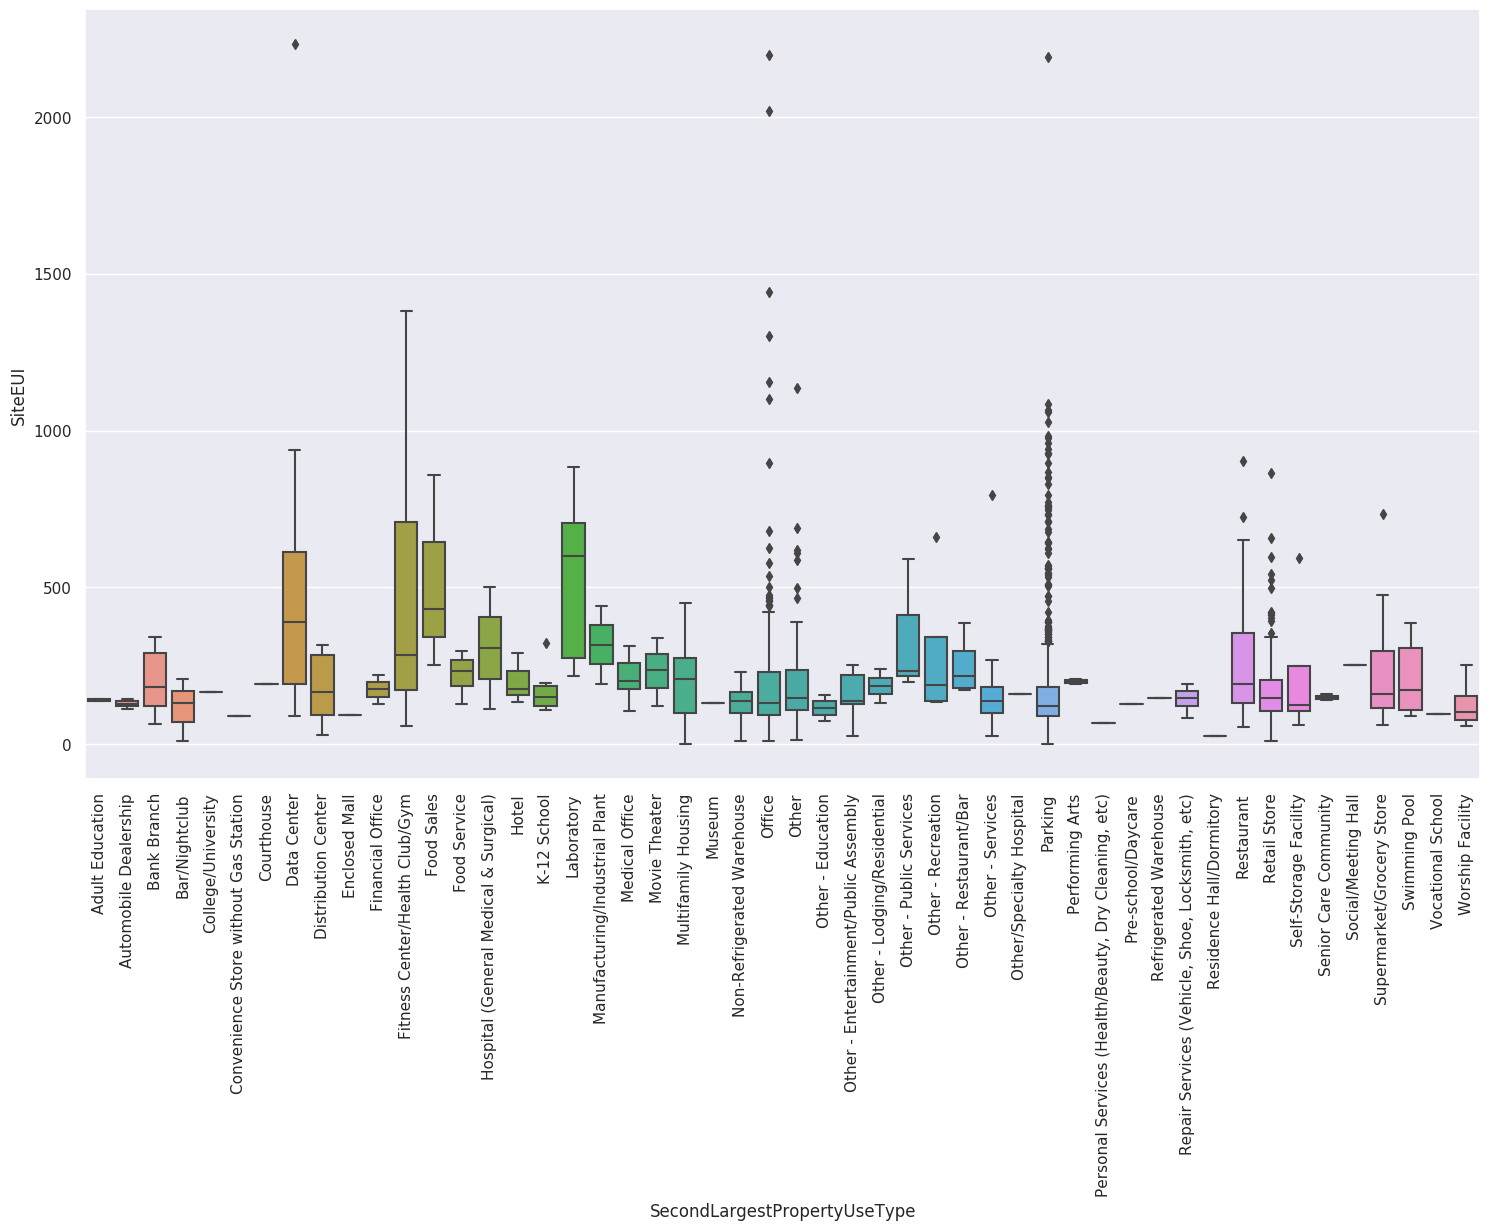

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SiteEUI   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     3.093
Date:                Sat, 18 Jan 2020   Prob (F-statistic):           1.01e-11
Time:                        13:44:51   Log-Likelihood:                -11132.
No. Observations:                1678   AIC:                         2.236e+04
Df Residuals:                    1628   BIC:                         2.263e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================================
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                 140.8525    132.108      1.066      0.286    -118.267     399.972
C(SecondLargestPropertyUseType)[T.Automobile Dealership]                                  -11.3565    186.829     -0.061      0.952    -377.807     355.094
C(SecondLargestPropertyUseType)[T.Bank Branch]                                             60.6357    149.796      0.405      0.686    -233.178     354.450
C(SecondLargestPropertyUseType)[T.Bar/Nightclub]                                          -24.4481    170.551     -0.143      0.886    -358.970     310.074
C(SecondLargestPropertyUseType)[T.College/University]                                      27.2872    228.818      0.119      0.905    -421.521     476.095
C(SecondLargestPropertyUseType)[T.Convenience Store without Gas Station]                  -51.2621    228.818     -0.224      0.823    -500.070     397.546
C(SecondLargestPropertyUseType)[T.Courthouse]                                              50.0003    228.818      0.219      0.827    -398.808     498.808
C(SecondLargestPropertyUseType)[T.Data Center]                                            395.4037    141.907      2.786      0.005     117.065     673.743
C(SecondLargestPropertyUseType)[T.Distribution Center]                                     39.9056    149.796      0.266      0.790    -253.908     333.719
C(SecondLargestPropertyUseType)[T.Enclosed Mall]                                          -46.8457    228.818     -0.205      0.838    -495.654     401.962
C(SecondLargestPropertyUseType)[T.Financial Office]                                        34.2273    186.829      0.183      0.855    -332.223     400.678
C(SecondLargestPropertyUseType)[T.Fitness Center/Health Club/Gym]                         319.6621    139.663      2.289      0.022      45.724     593.600
C(SecondLargestPropertyUseType)[T.Food Sales]                                             372.5046    170.551      2.184      0.029      37.983     707.026
C(SecondLargestPropertyUseType)[T.Food Service]                                            81.5462    161.799      0.504      0.614    -235.809     398.901
C(SecondLargestPropertyUseType)[T.Hospital (General Medical & Surgical)]                  165.7737    186.829      0.887      0.375    -200.676     532.224
C(SecondLargestPropertyUseType)[T.Hotel]                                                   60.5156    170.551      0.355      0.723    -274.006     395.037
C(SecondLargestPropertyUseType)[T.K-12 School]                                             33.4387    152.545      0.21

,sum_sq,df,F,PR(>F)
C(SecondLargestPropertyUseType),5.289444e+06,49.0,3.092618,1.012521e-11
Residual,5.682535e+07,1628.0,NaN,NaN


In [33]:
_ = bivar.anova(outcome_variable='SiteEUI', 
                group='SecondLargestPropertyUseType', 
                figsize=(18, 10), label_rotation=90)

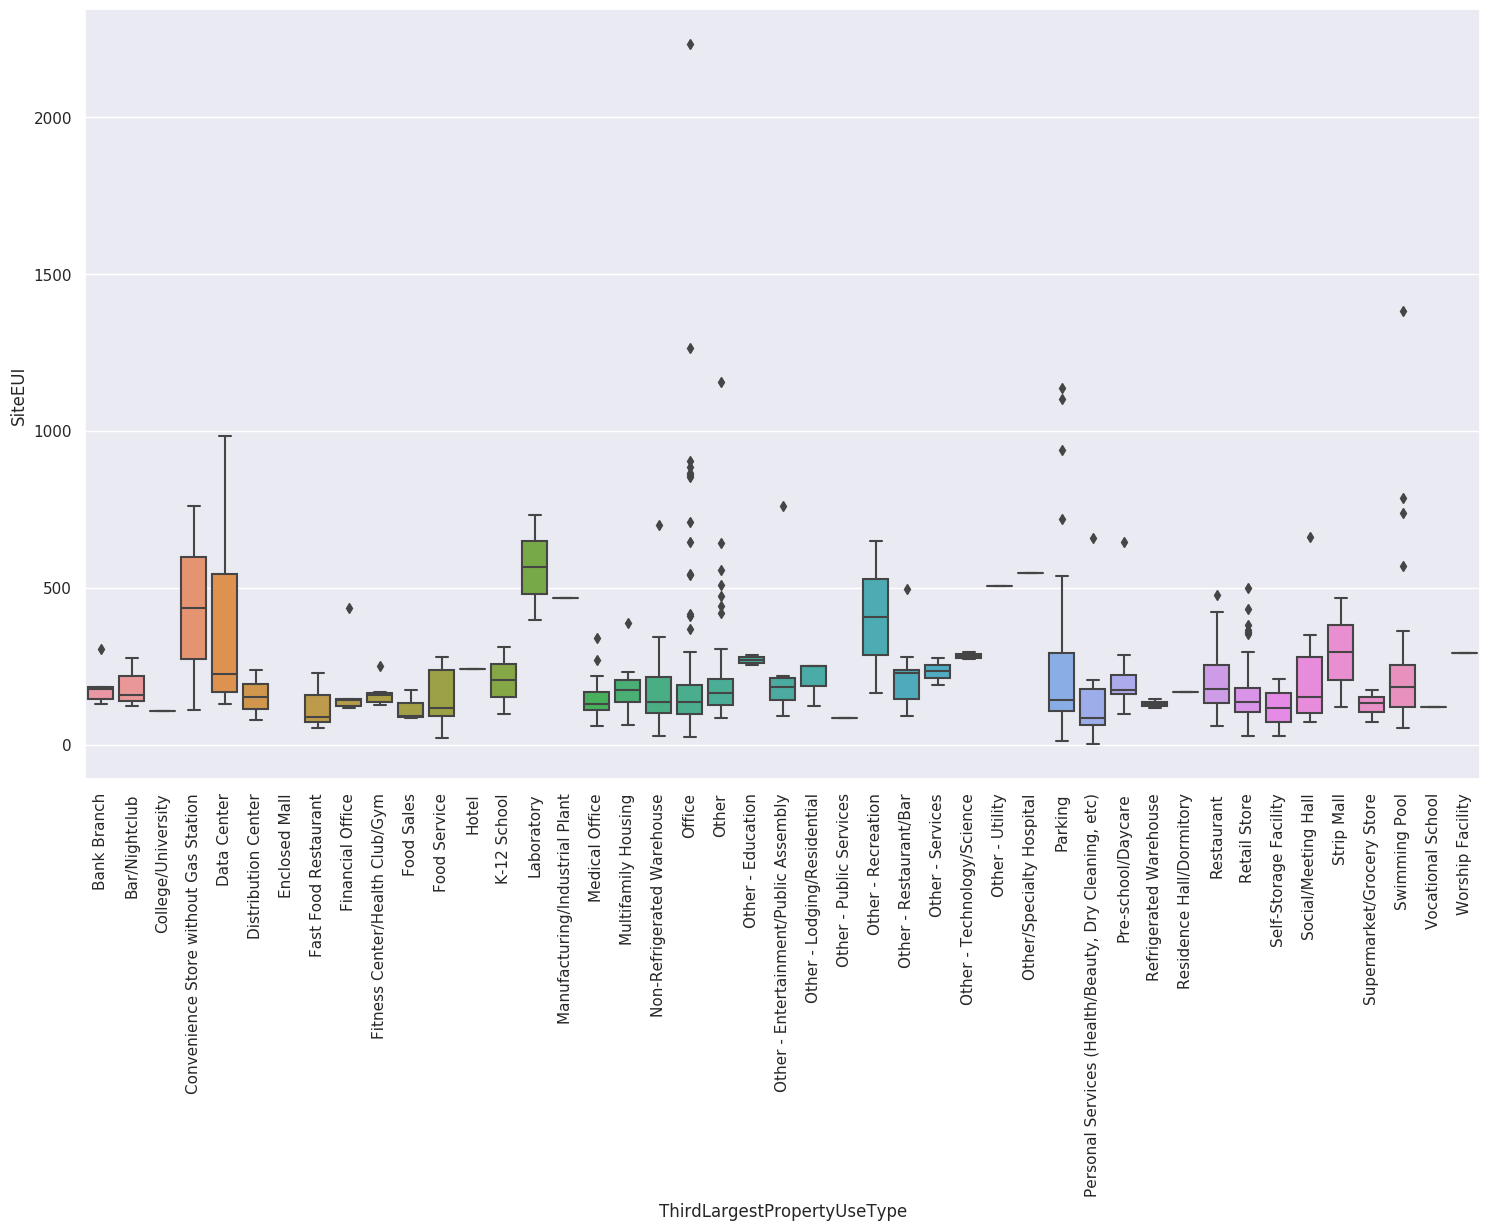

/home/thibault/Documents/openclassrooms/projects/seattle_energy/env/lib/python3.6/site-packages/statsmodels/base/model.py:1752: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 44, but rank is 43
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SiteEUI   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.181
Date:                Sat, 18 Jan 2020   Prob (F-statistic):              0.205
Time:                        13:46:10   Log-Likelihood:                -3965.4
No. Observations:                 596   AIC:                             8019.
Df Residuals:                     552   BIC:                             8212.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================================
                                                                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                184.4910     79.595      2.318      0.021      28.145     340.837
C(ThirdLargestPropertyUseType)[T.Bar/Nightclub]                                            1.1041    137.862      0.008      0.994    -269.695     271.903
C(ThirdLargestPropertyUseType)[T.College/University]                                     -78.4967    210.588     -0.373      0.709    -492.149     335.155
C(ThirdLargestPropertyUseType)[T.Convenience Store without Gas Station]                  250.5271    159.190      1.574      0.116     -62.164     563.219
C(ThirdLargestPropertyUseType)[T.Data Center]                                            195.0739     95.134      2.051      0.041       8.205     381.943
C(ThirdLargestPropertyUseType)[T.Distribution Center]                                    -28.9697    137.862     -0.210      0.834    -299.768     241.829
C(ThirdLargestPropertyUseType)[T.Enclosed Mall]                                        -1.317e-14   1.52e-13     -0.086      0.931   -3.12e-13    2.86e-13
C(ThirdLargestPropertyUseType)[T.Fast Food Restaurant]                                   -60.7259    137.862     -0.440      0.660    -331.525     210.073
C(ThirdLargestPropertyUseType)[T.Financial Office]                                         8.8223    118.058      0.075      0.940    -223.076     240.721
C(ThirdLargestPropertyUseType)[T.Fitness Center/Health Club/Gym]                         -19.8213    112.564     -0.176      0.860    -240.928     201.285
C(ThirdLargestPropertyUseType)[T.Food Sales]                                             -67.5608    137.862     -0.490      0.624    -338.360     203.238
C(ThirdLargestPropertyUseType)[T.Food Service]                                           -26.1592     98.949     -0.264      0.792    -220.522     168.204
C(ThirdLargestPropertyUseType)[T.Hotel]                                                   56.2043    210.588      0.267      0.790    -357.448     469.856
C(ThirdLargestPropertyUseType)[T.K-12 School]                                             20.0842    159.190      0.126      0.900    -292.607     332.776
C(ThirdLargestPropertyUseType)[T.Laboratory]                                             380.0230    159.190      2.387      0.017      67.332     692.715
C(ThirdLargestPropertyUseType)[T.Manufacturing/Industrial Plant]                         283.6503    210.588      1.347      0.179    -130.002     697.302
C(ThirdLargestPropertyUseType)[T.Medical Office]                                         -35.3902     92.581     -0.382      0.702    -217

,sum_sq,df,F,PR(>F)
C(ThirdLargestPropertyUseType),1.975193e+06,44.0,1.180963,0.205173
Residual,2.098262e+07,552.0,NaN,NaN


In [34]:
_ = bivar.anova(outcome_variable='SiteEUI', 
                group='ThirdLargestPropertyUseType', 
                figsize=(18, 10), label_rotation=90)